In [0]:
!pip install rasterio

In [0]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from PIL import Image


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def get_eval_window(raster_ds, mask_ds, x, y):
    window = rio.windows.Window(x, y, WINDOW_SIZE, WINDOW_SIZE)

    if CHANNELS == 3:
        bands = [5, 3, 2]
    else:
        bands = raster_ds.indexes[0:CHANNELS]

    # Nodata
    nodata = raster_ds.read(1, window=window) == MAGIC_NUMBER
    not_nodata = (nodata == 0)

    # Labels
    labels = mask_ds.read(1, window=window) == OTHER_MAGIC_NUMBER
    labels = (labels*not_nodata) + (2*nodata)  # class 2 ignored

    # Normalized float32 imagery bands
    data = []
    for band in bands:
        a = raster_ds.read(band, window=window)
        a = np.array((a - MEANS[band-1]) / STDS[band-1], dtype=np.float32)
        a = a * not_nodata
        data.append(a)
    data = np.stack(data, axis=0)

    return (data, labels)

# Buildings

In [0]:
MEANS = [282.25613565591533, 434.92568434644414, 576.778925128917, 431.0893725326917, 413.849793435062, 407.8019863596957, 540.9877607404478, 346.13134404092824]
STDS = [93.98737081435225, 204.11210503974044, 321.96208260604055, 274.7927091658248, 284.49701298475304, 241.7486663735505, 325.7805731808835, 208.77036985582086]
MAGIC_NUMBER = 2**16 - 1
OTHER_MAGIC_NUMBER = 2**8 - 1
WINDOW_SIZE = 1024
CHANNELS = 8

np.random.seed(seed=33)

In [0]:
raster_ds = rio.open('/content/gdrive/My Drive/SpaceNet/VegasBuildings/mul.tif')
mask_ds = rio.open('/content/gdrive/My Drive/SpaceNet/VegasBuildings/mask.tif')

In [0]:
width = raster_ds.width
height = raster_ds.height
data, labels = get_eval_window(raster_ds, mask_ds, width//2, height//2)

In [0]:
blue = data[1]*0.125 + 0.5
green = data[2]*0.125 + 0.5
red = data[4]*0.125 + 0.5
rgb = np.stack([red, green, blue], axis=2)

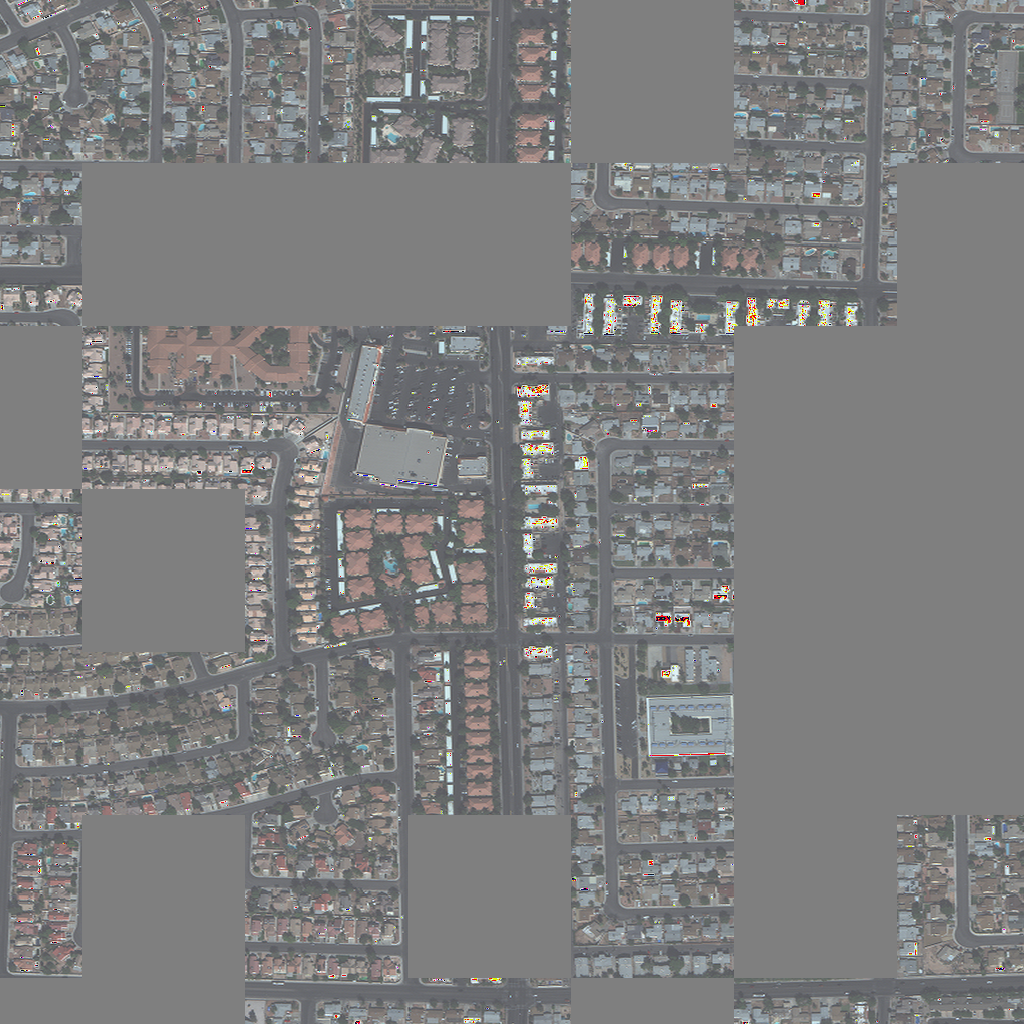

In [8]:
a = np.uint8(rgb*255)
Image.fromarray(a)

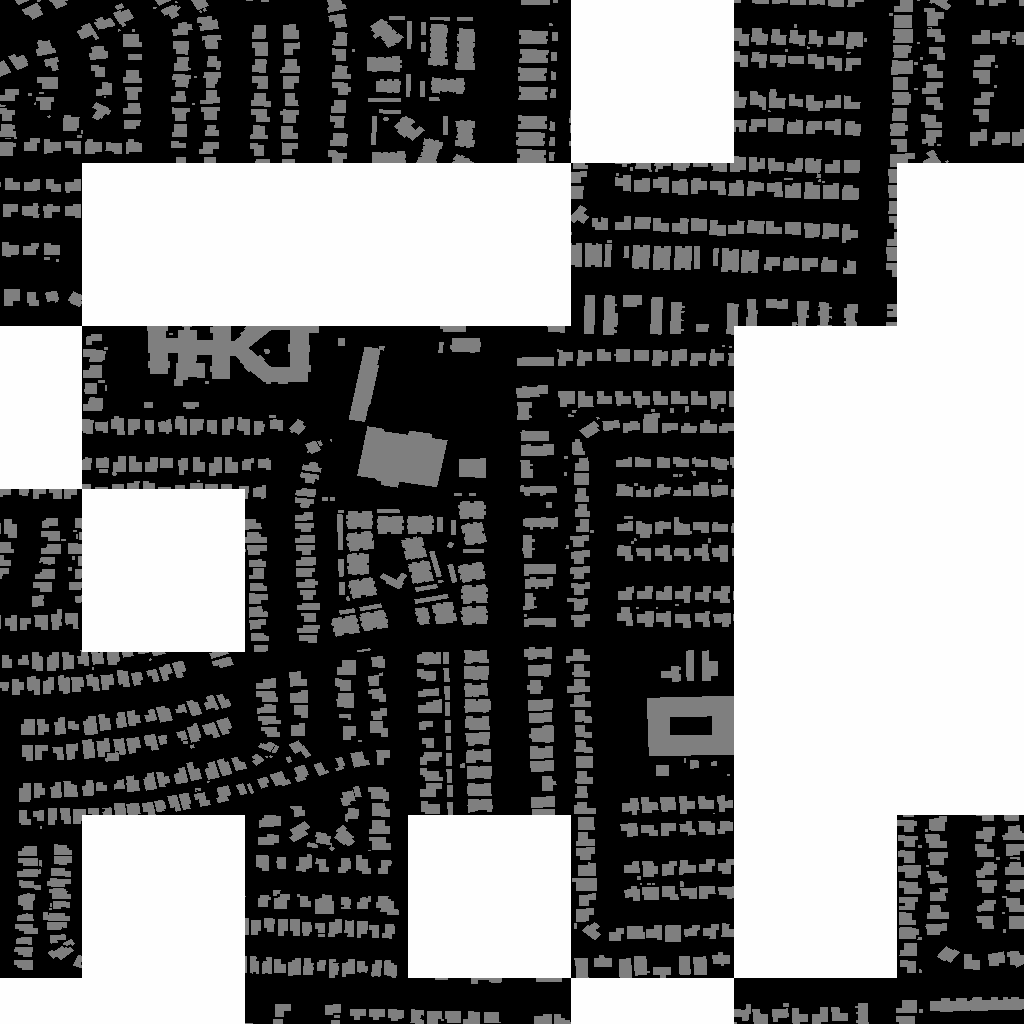

In [9]:
b = np.uint8(labels*127)
Image.fromarray(b)

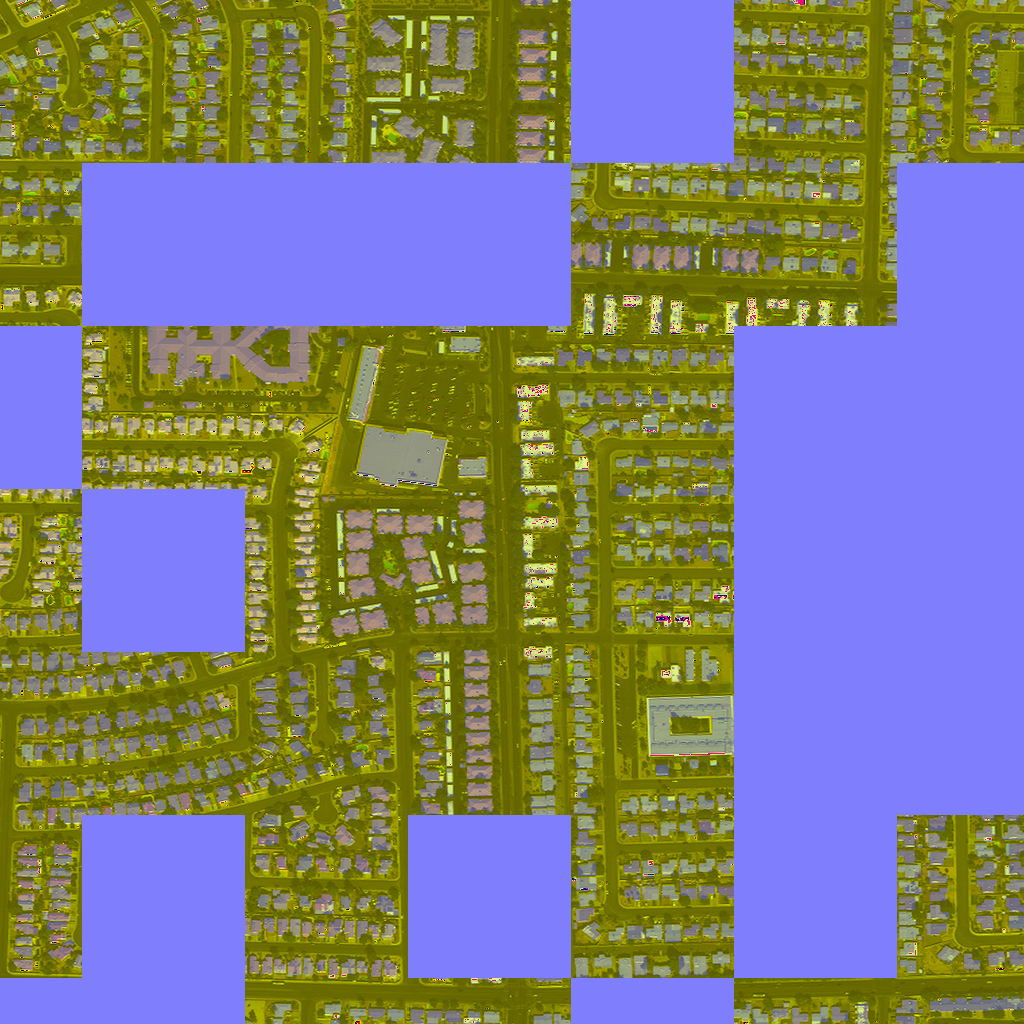

In [10]:
Image.fromarray(np.stack([a[:,:,0], a[:,:,1], b], axis=2))

In [0]:
device = torch.device("cuda")

if True:
  deeplab = torch.load('/content/gdrive/My Drive/SpaceNet/VegasBuildings/deeplab_8channels.pth').to(device)
  deeplab5x = torch.load('/content/gdrive/My Drive/SpaceNet/VegasBuildings/deeplab_8channels5x.pth').to(device)
  deeplab0pt2x = torch.load('/content/gdrive/My Drive/SpaceNet/VegasBuildings/deeplab_8channelsFifth.pth').to(device)

In [0]:
batch = torch.unsqueeze(torch.from_numpy(data), dim=0).to(device)

In [0]:
deeplab.eval()
deeplab5x.eval()
deeplab0pt2x.eval()
with torch.no_grad():
  out = deeplab(batch)['out'].data.cpu().numpy()[0]
  out5x = deeplab5x(batch)['out'].data.cpu().numpy()[0]
  out0pt2x = deeplab0pt2x(batch)['out'].data.cpu().numpy()[0]

In [0]:
pred = np.apply_along_axis(np.argmax, 0, out)
pred5x = np.apply_along_axis(np.argmax, 0, out5x)
pred0pt2x = np.apply_along_axis(np.argmax, 0, out0pt2x)
gt = labels

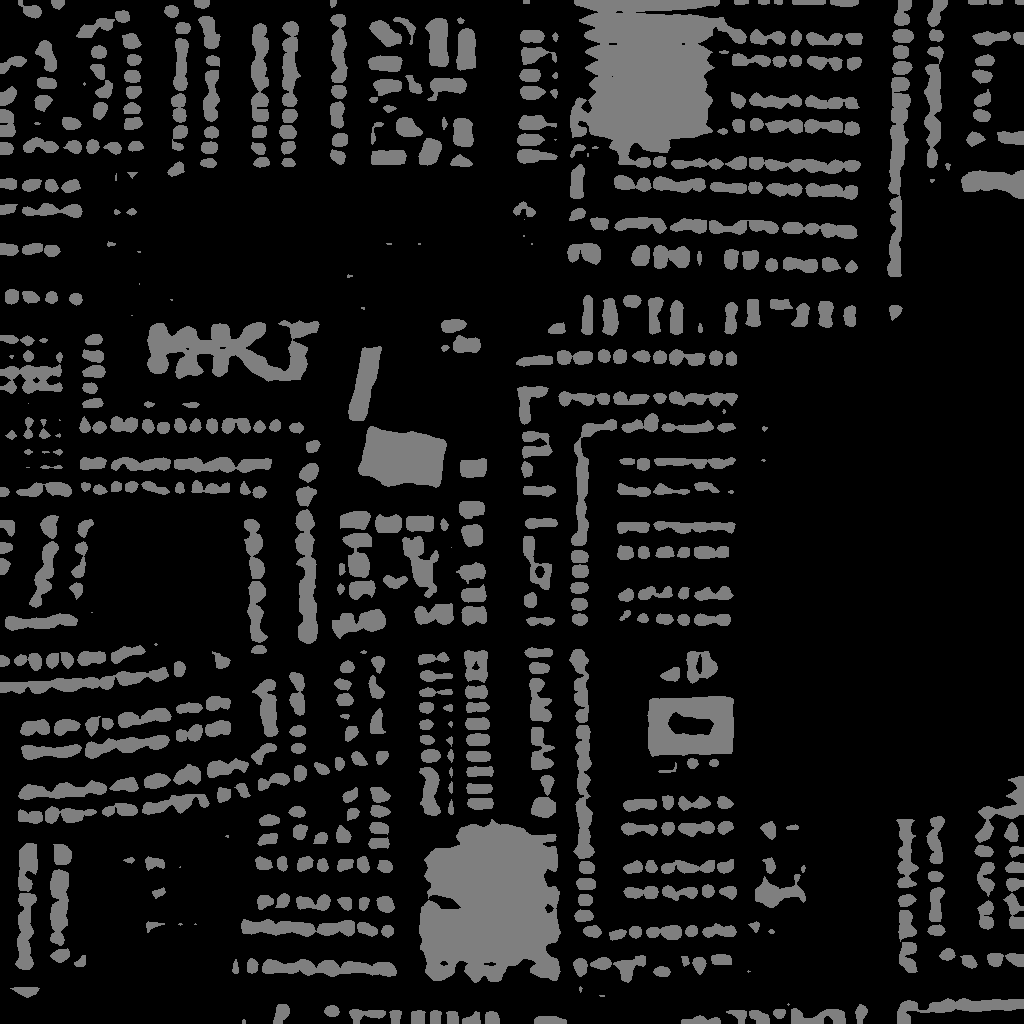

In [15]:
Image.fromarray(np.uint8(pred * 127))

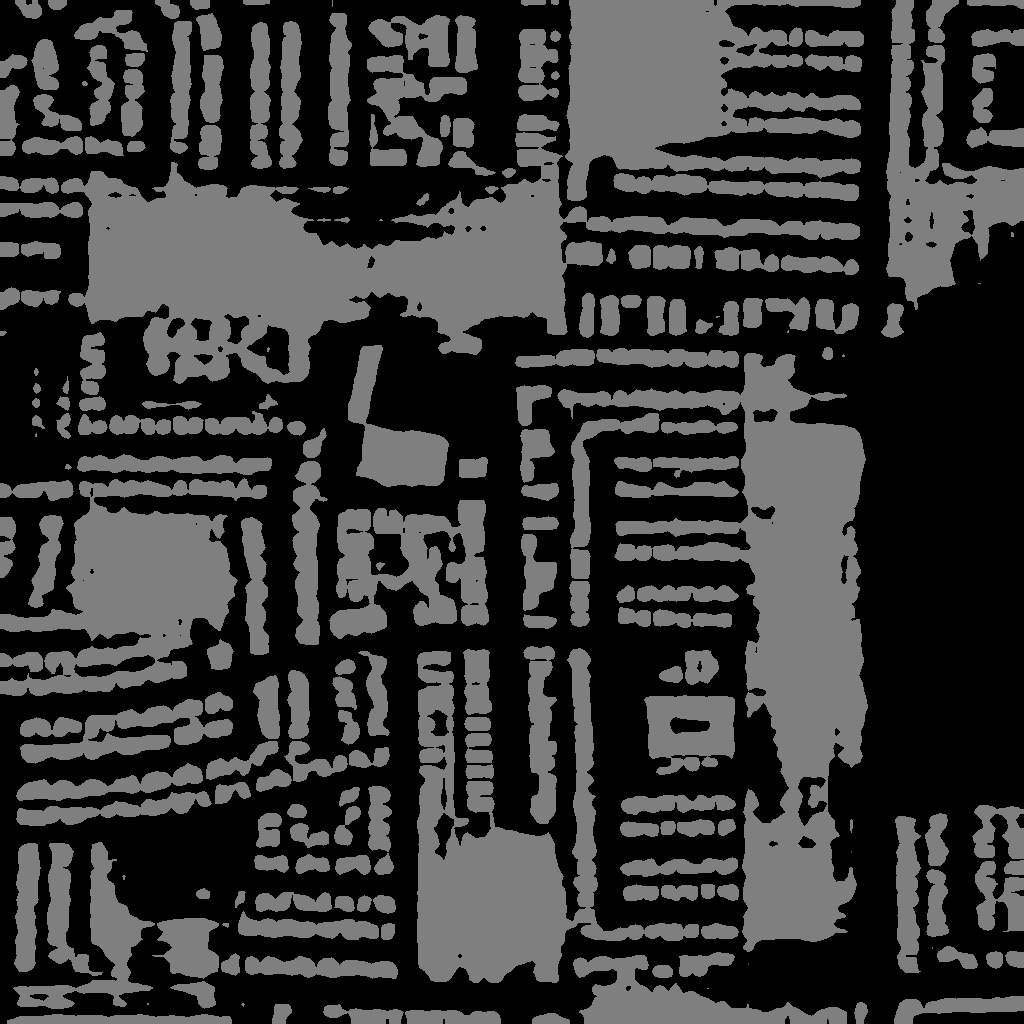

In [16]:
Image.fromarray(np.uint8(pred5x * 127))

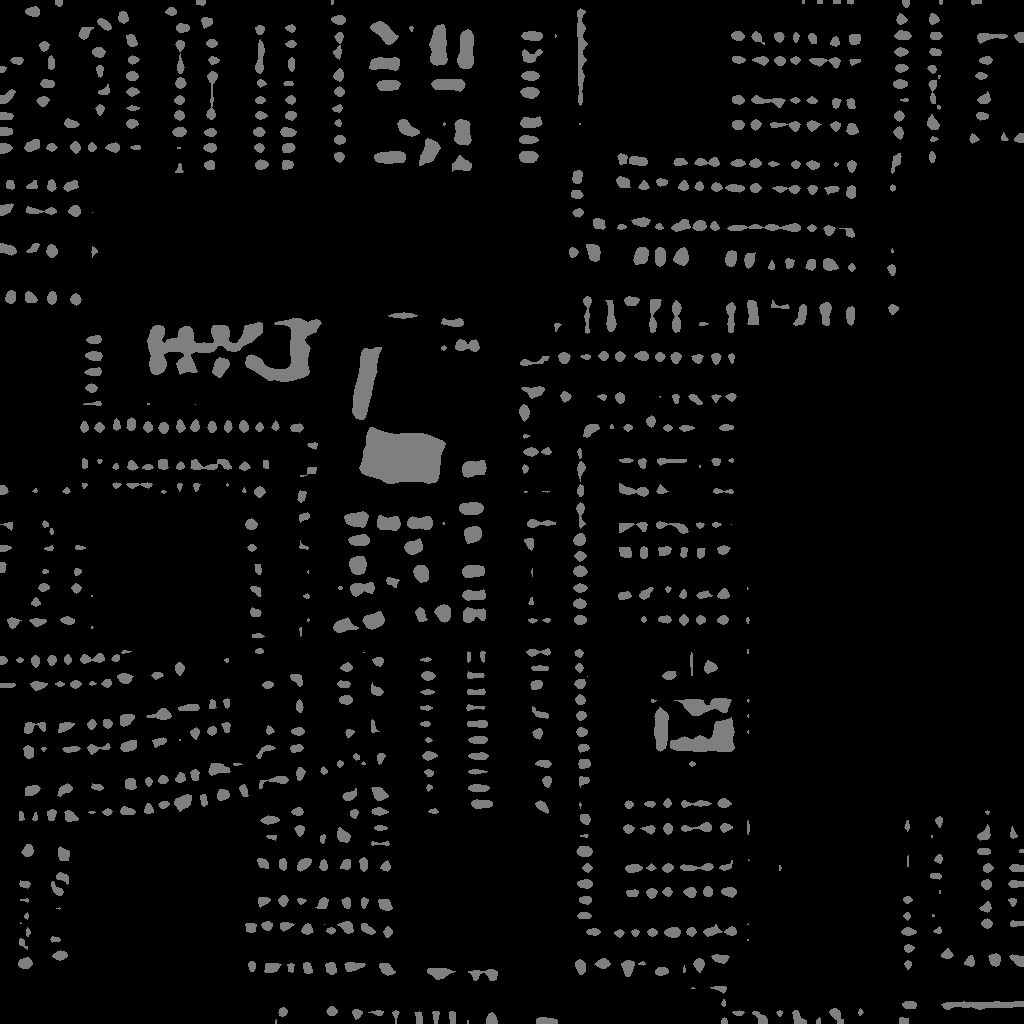

In [17]:
Image.fromarray(np.uint8(pred0pt2x * 127))

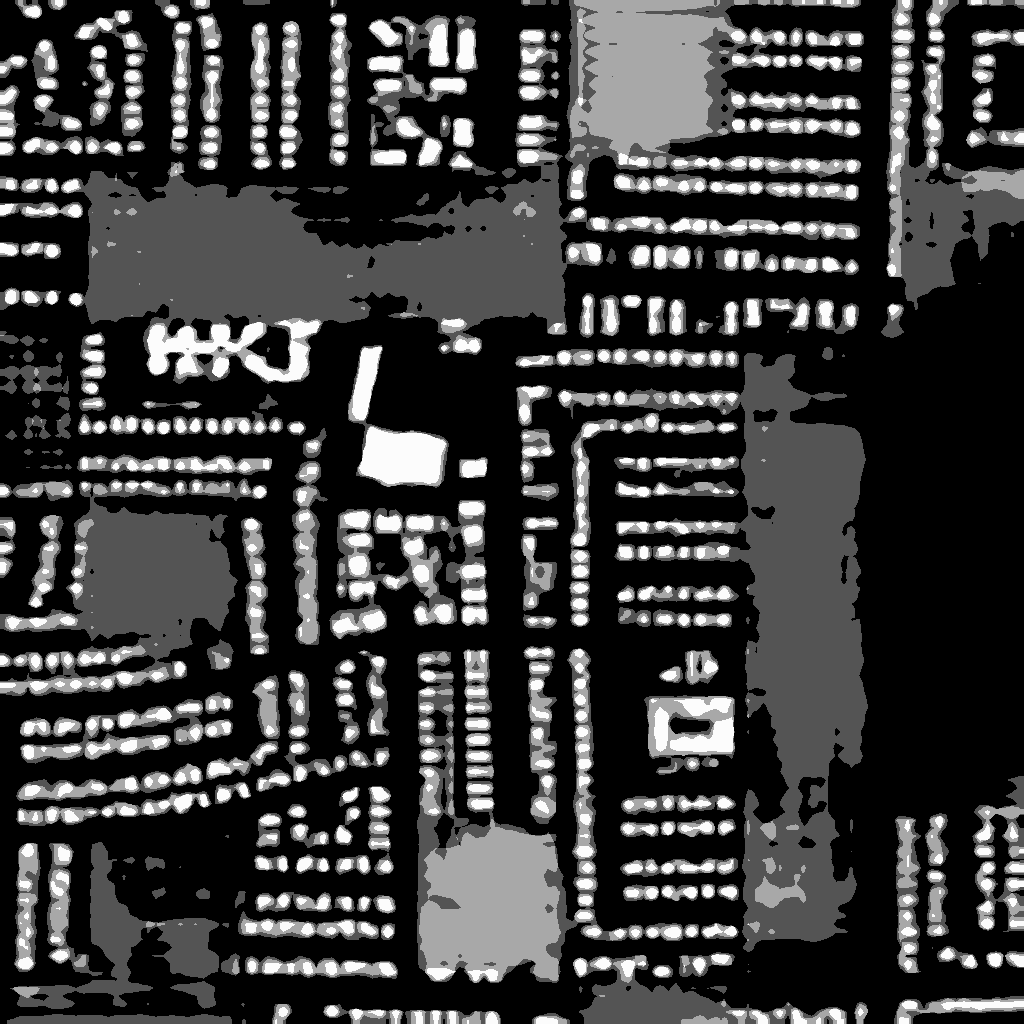

In [18]:
Image.fromarray(np.uint8((pred5x+pred+pred0pt2x) * 84))

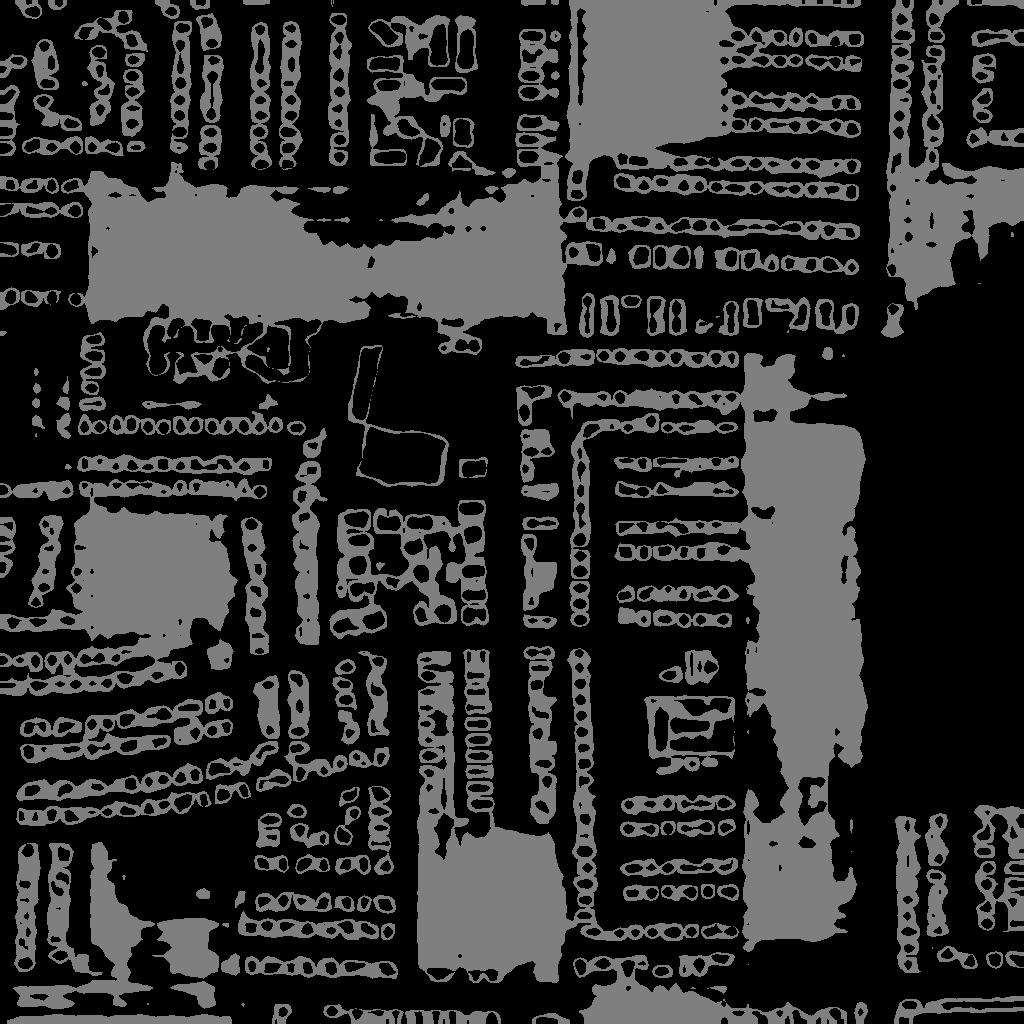

In [19]:
Image.fromarray(np.uint8((pred5x-pred0pt2x) * 127))

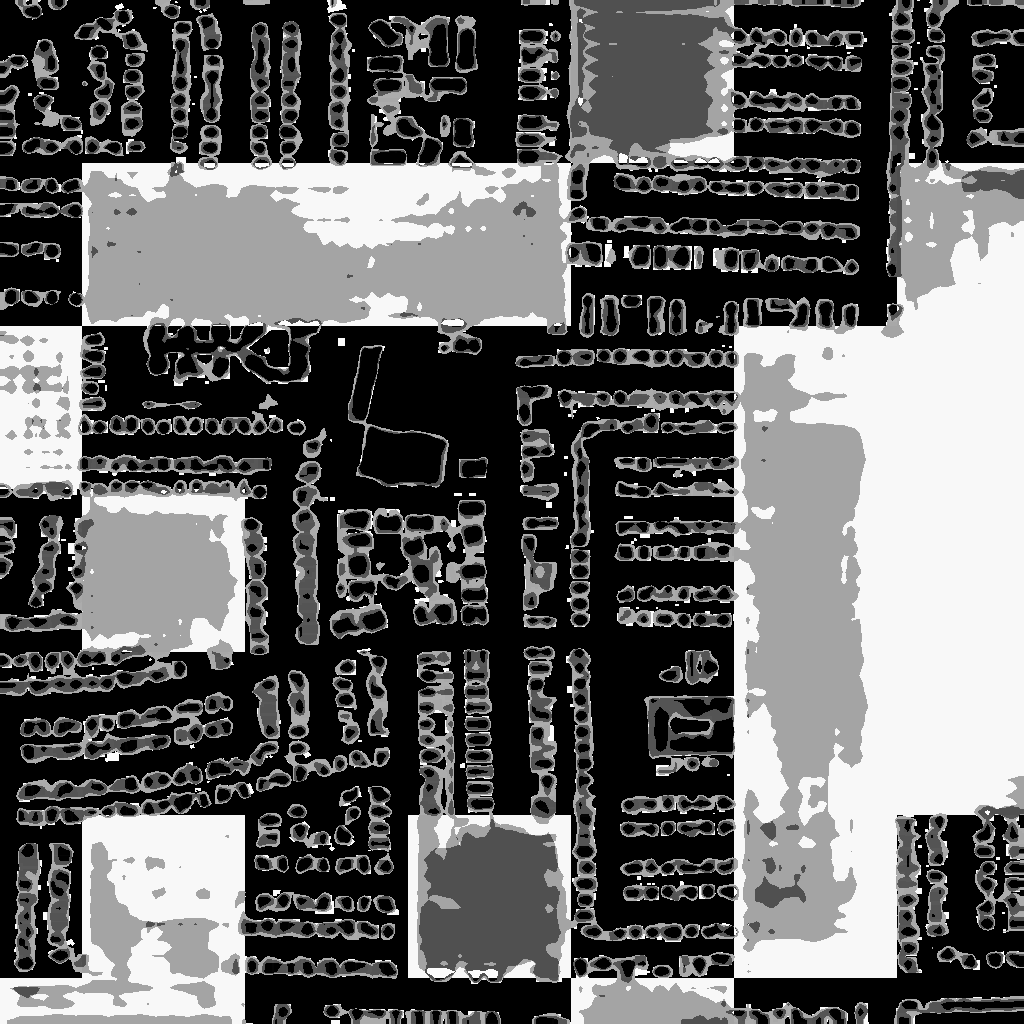

In [20]:
Image.fromarray(np.uint8((gt*3 - pred5x - pred - pred0pt2x) * 84))

# Roads

In [0]:
MEANS = [273.1252314824011, 419.91463924710274, 556.1327121603915, 415.50296386404295, 398.6837312017997, 393.5218239641979, 522.2630891139817, 334.0604837448621]
STDS = [103.58464807477723, 212.265981094452, 329.048207907673, 278.23427823230975, 286.6897135936873, 246.27197877733886, 332.1166608522964, 212.81459707862774]
MAGIC_NUMBER = 2**16 - 1
OTHER_MAGIC_NUMBER = 2**8 - 1
WINDOW_SIZE = 1024
CHANNELS = 8

np.random.seed(seed=33)

In [0]:
raster_ds = rio.open('/content/gdrive/My Drive/SpaceNet/VegasRoads/mul.tif')
mask_ds = rio.open('/content/gdrive/My Drive/SpaceNet/VegasRoads/mask.tif')

In [0]:
width = raster_ds.width
height = raster_ds.height
data, labels = get_eval_window(raster_ds, mask_ds, width//2, height//2)

In [0]:
blue = data[1]*0.125 + 0.5
green = data[2]*0.125 + 0.5
red = data[4]*0.125 + 0.5
rgb = np.stack([red, green, blue], axis=2)

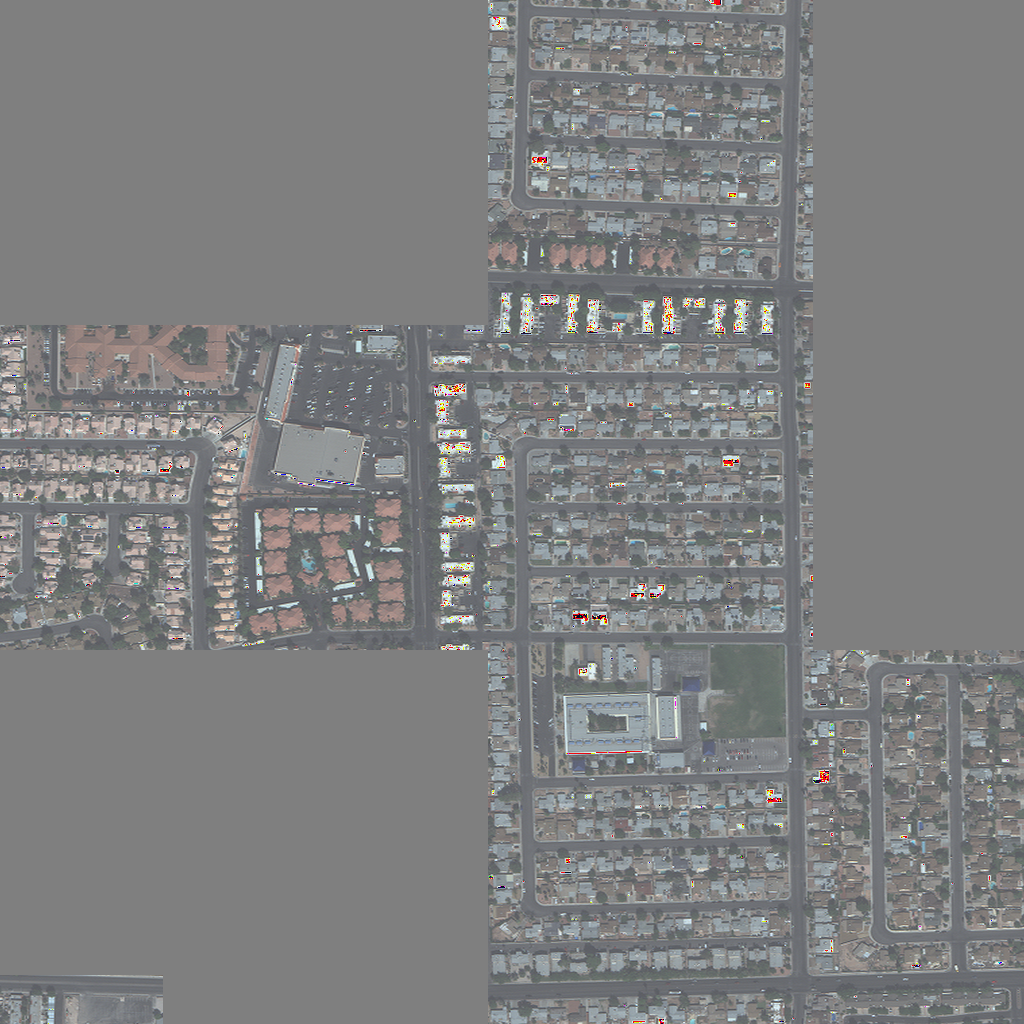

In [25]:
a = np.uint8(rgb*255)
Image.fromarray(a)

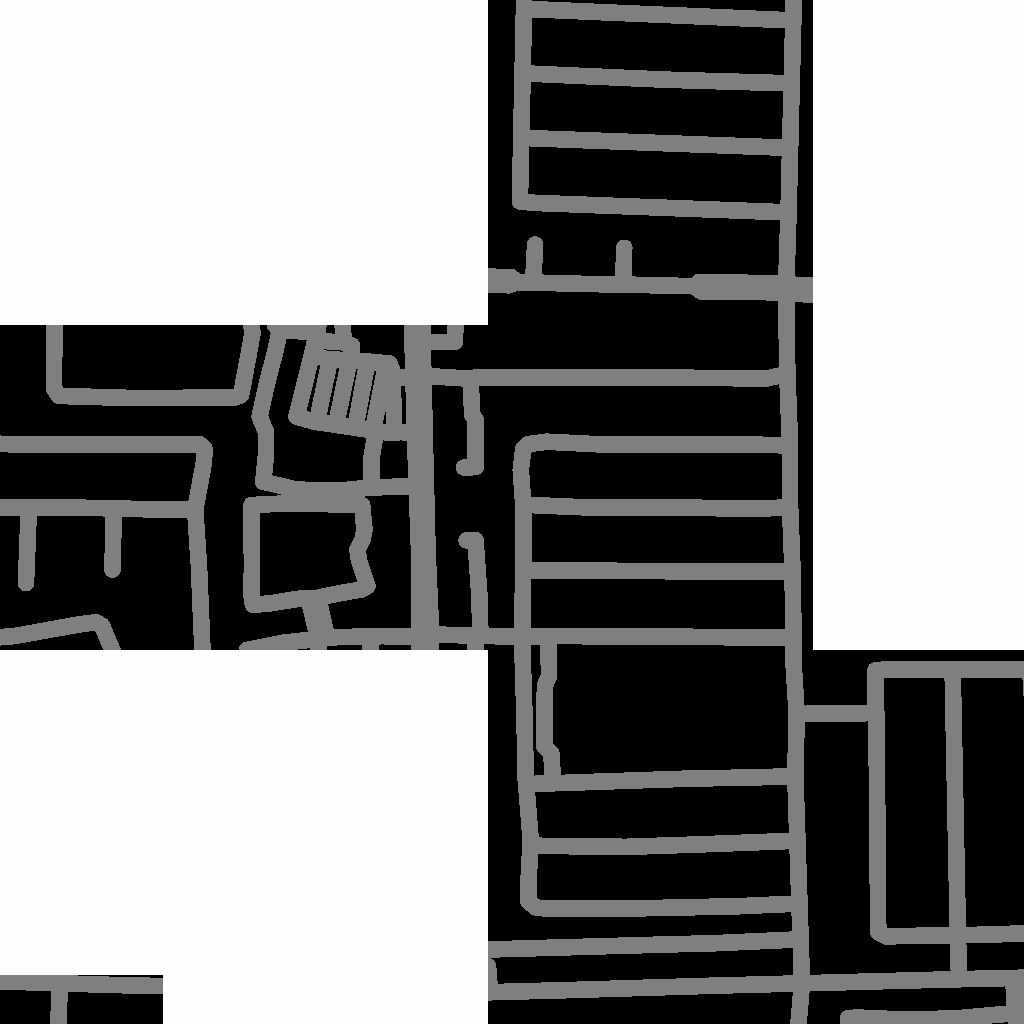

In [26]:
b = np.uint8(labels*127)
Image.fromarray(b)

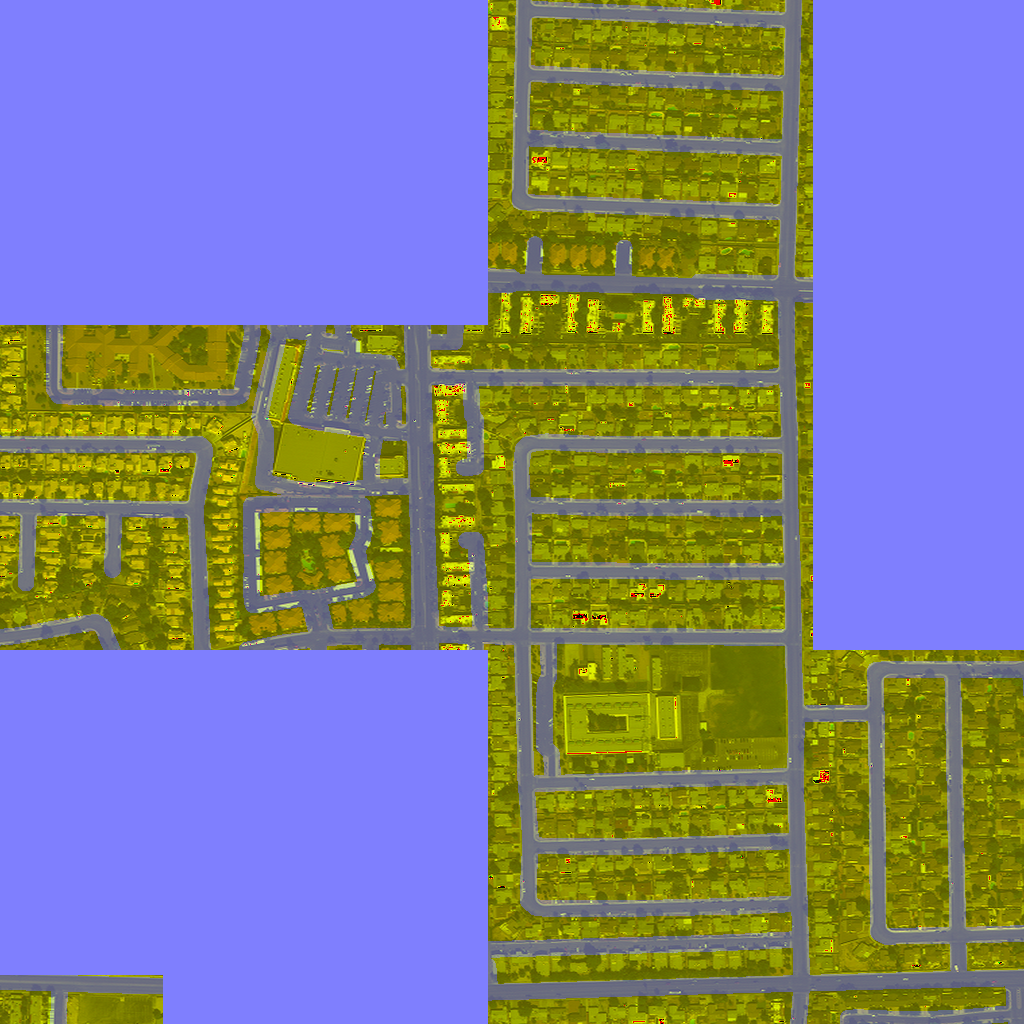

In [27]:
Image.fromarray(np.stack([a[:,:,0], a[:,:,1], b], axis=2))

In [0]:
device = torch.device("cuda")

if True:
  deeplab5x = None
  deeplab0pt2x = None
  deeplab = torch.load('/content/gdrive/My Drive/SpaceNet/VegasRoads/deeplab_8channels.pth').to(device)

In [0]:
batch = torch.unsqueeze(torch.from_numpy(data), dim=0).to(device)

In [0]:
deeplab.eval()
with torch.no_grad():
  out = deeplab(batch)['out'].data.cpu().numpy()[0]

In [0]:
pred = np.apply_along_axis(np.argmax, 0, out)
gt = labels

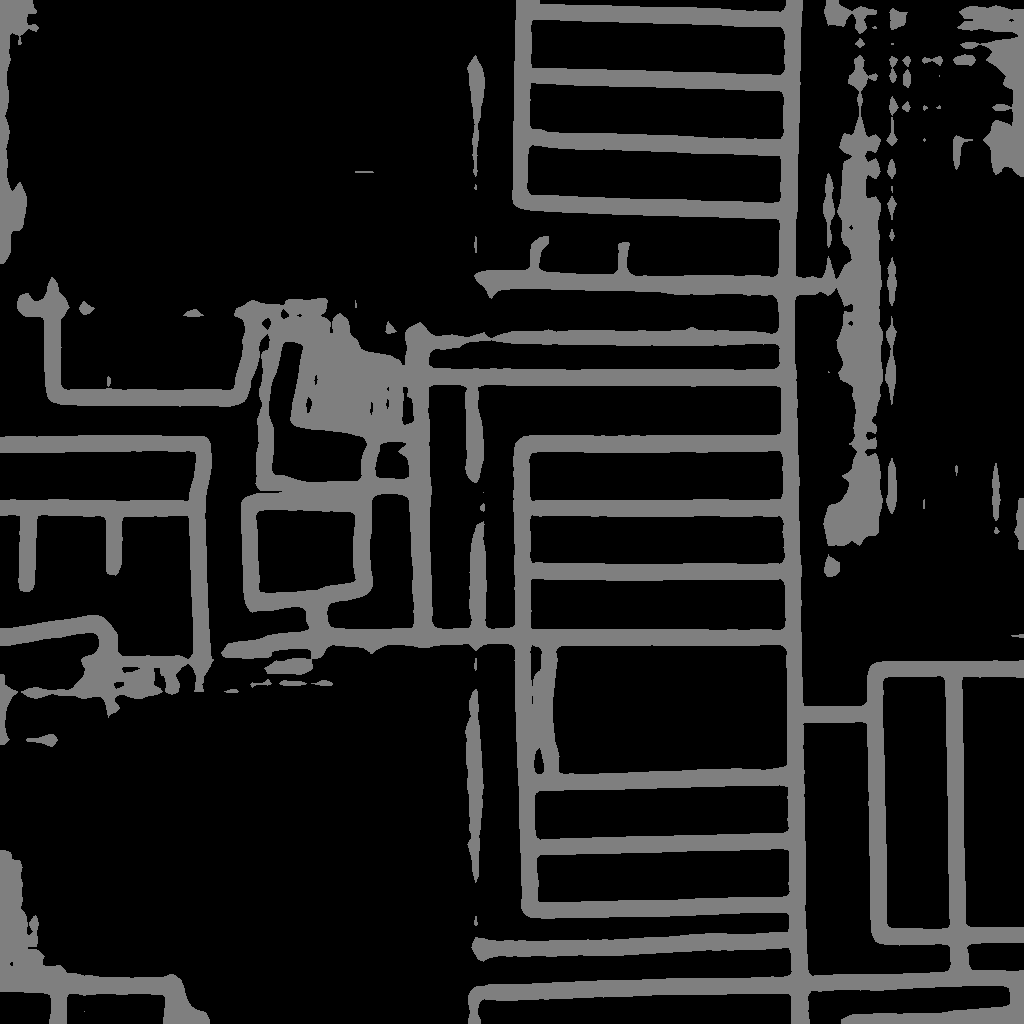

In [32]:
Image.fromarray(np.uint8(pred * 127))

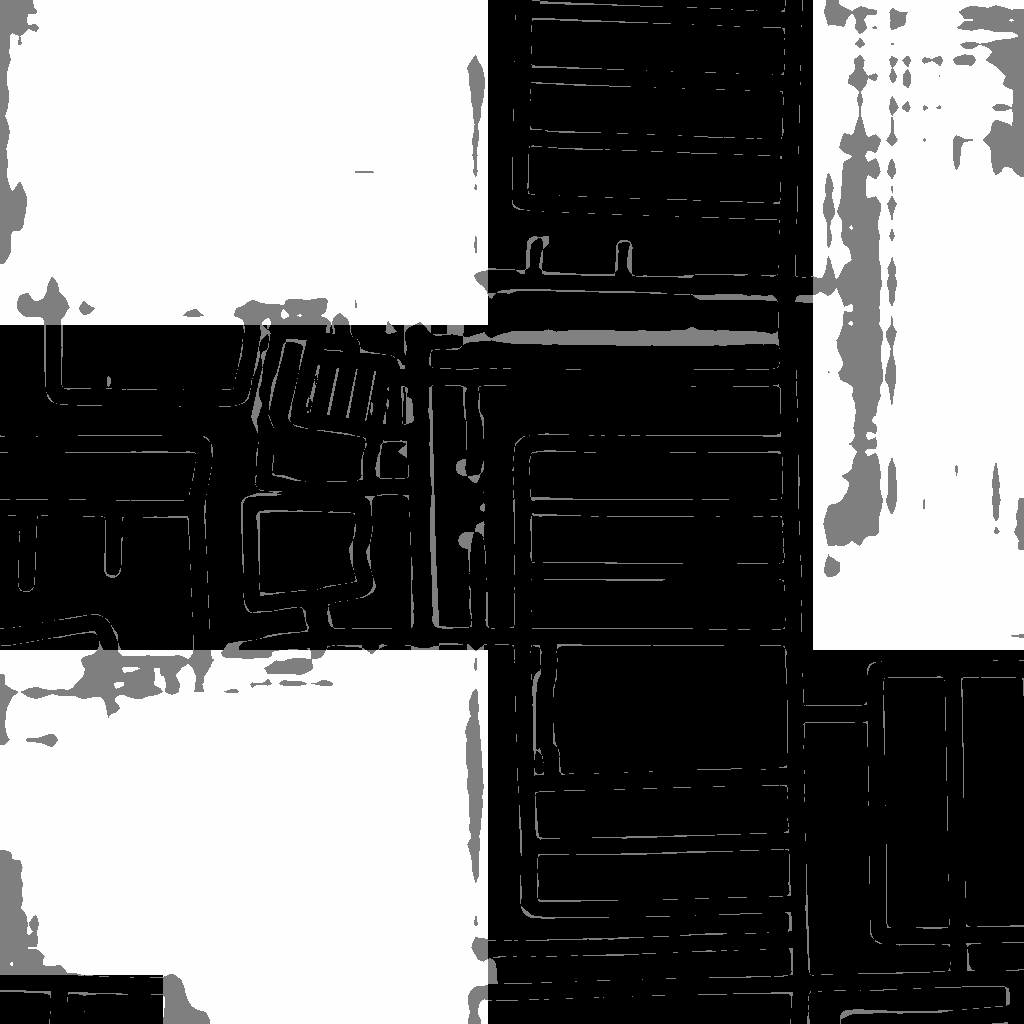

In [33]:
Image.fromarray(np.uint8((gt-pred) * 127))